In [1]:
# study website http://karpathy.github.io/2015/05/21/rnn-effectiveness/

![种类](img/classifier.png)

- 像图片分类 一对一
- 像图像中物体识别 一对多
- 像情感分析 多对一
- 像翻译 多对多
- 实时翻译 多对多

![char](img/mini-char-example.png)

 $$\begin{split}h_{t} &=tanh(W_{hx}x+W_{hh}h_{t-1}) \\ y &= softmax(W_{yh}h)\end{split}$$
 - 定义好损失函数，就可以让下一个字符对应的位置尽可能地大，这样子在预测的时候就可以去向量中最大的值的索引做为待预测值的索引

## 交叉损失函数
$$ J = - \sum_{c=1}^{M}y_{c}log(p_{c})$$
- M——类别的数量；
- y——指示变量（0或1）,如果该类别和样本的类别相同就是1，否则是0；
- p——对于观测样本属于类别c的预测概率。

### [DL 最全的优化方法](https://zhuanlan.zhihu.com/p/22252270)

![adagrad](img/adagrad.jpg)
- 采用累积平方梯度
- 优点是使得更新的更加平缓，更新速度更快
- 缺点是由于是累积平方梯度，导致学习率为0

### mnist_实验, numpy

In [128]:
#### 定义一些参数
import numpy as np
learning_rate = 1e-4
batch_size = 2000


# unite_size = 
from tensorflow.examples.tutorials.mnist import input_data

In [129]:
mn = input_data.read_data_sets('MNIST_DATA',one_hot = True)

Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz


In [130]:
num_iterator = 3000;
time_step = 28
hidden_size = 400
feature_size = 28
import matplotlib.pyplot as plts

In [131]:
# def tanh(X):
#     Y = (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
#     return Y

![tanh_overflow](img/tanh_overflow.png)

In [132]:
# def sigmod(X): ### nice
#     return .5 * (1 + np.tanh(.5 * X))

In [133]:
def softmax(X):
    sum_ = np.sum(np.exp(X), axis = 0)
    y = np.exp(X) / sum_
    return y

In [134]:
# x = np.arange(-10,10,0.1)
# x = np.array([[1,2,3],[2,3,4]])
# y = softmax(x)
# np.sum(y,axis = 0)

In [135]:
### 这里参数矩阵的大小如何定义？每一个点为特征进行的加权
### [hidden_size,feature_size]
# Wx = np.random.standard_normal([hidden_size,feature_size])
# ### [hidden_size,hidden_size]
# Wh = np.random.standard_normal([hidden_size,hidden_size])
# bh = np.zeros([hidden_size,1])
# ### [class_size,hidden_size]
# Wy = np.random.standard_normal([10,hidden_size])
# by = np.zeros([10,1])
def init_params():
    params = {}
    params['h0'] = np.zeros([hidden_size,batch_size])
    for i in range(time_step): ## 每一步拿出所有数据的第一行来进行训练
        params['Wx' + str(i + 1)] = np.random.standard_normal([hidden_size,feature_size])
        params['Wh' + str(i + 1)] = np.random.standard_normal([hidden_size,hidden_size])
        params['bh' + str(i + 1)] = np.zeros([hidden_size,1])
        params['mWx' + str(i + 1)] = np.zeros_like(params['Wx' + str(i + 1)])
        params['mWh' + str(i + 1)] = np.zeros_like(params['Wh' + str(i + 1)])
        params['mbh' + str(i + 1)] = np.zeros_like(params['bh' + str(i + 1)])
        
    params['Wy'] = np.random.standard_normal([10,hidden_size])
    params['by'] = np.zeros([10,1])
    params['mWy'] = np.zeros_like(params['Wy'])
    params['mby'] = np.zeros_like(params['by'])
    
    return params

def forward(X,label,params):
    X = X.reshape(-1,time_step,feature_size)
    
    for i in range(time_step): ## 每一步拿出所有数据的第一行来进行训练
        x = X[:,i,:]
        params['h' + str(i + 1)] = np.tanh(np.dot(params['Wh' + str(i + 1)], params['h'+ str(i)]) + params['bh'+ str(i + 1)] + np.dot(params['Wx' + str(i + 1)],x.transpose()))
        
    y = softmax(np.dot(params['Wy'] ,params['h' + str(time_step)]) + params['by'])
    
    y_pred = y

    index = label.argmax(axis = 1)
    y_pred[index,range(y_pred.shape[1])] -= 1.0
    y_pred /= batch_size 
    
    dwy = np.dot(y_pred, params['h' + str(time_step)].transpose())
    dby = np.sum(y_pred, axis = 1,keepdims = True)
    dht = np.dot(params['Wy'].transpose(), y_pred)
    
    params['mWy'] += dwy * dwy
    params['mby'] += dby * dby
    
    params['Wy'] += -learning_rate * dwy / np.sqrt(params['mWy']  + 1e-8)
    params['by'] += -learning_rate * dby / np.sqrt(params['mby']  + 1e-8)
    
    
    X = X.reshape(-1,time_step,feature_size)
    for i in reversed(range(time_step)):
        x = X[:,i,:]
        dht = (1 - (params['h' + str(i + 1)] ** 2))  * dht ## be careful 
#         print(dht)
        dwh = np.dot(dht, params['h' + str(i)].transpose())
        dbh = np.sum(dht, axis = 1, keepdims = True)
        dwx = np.dot(dht,x)
        
        dht = np.dot(params['Wh' + str(i + 1)].transpose(),dht)
        
        params['mWx' + str(i + 1)] += dwx * dwx
        params['mWh' + str(i + 1)] += dwh * dwh
        params['mbh' + str(i + 1)] += dbh * dbh
        
        params['Wx' + str(i + 1)] = -learning_rate * dwx / np.sqrt(params['mWx' + str(i + 1)]  + 1e-8)
        params['Wh' + str(i + 1)] = -learning_rate * dwh / np.sqrt(params['mWh' + str(i + 1)]  + 1e-8)
        params['bh' + str(i + 1)] = -learning_rate * dbh / np.sqrt(params['mbh' + str(i + 1)]  + 1e-8)
        
    return params
def predict(X, params):
    X = X.reshape(-1,time_step,feature_size)
    for i in range(time_step): ## 每一步拿出所有数据的第一行来进行训练
        x = X[:,i,:]
        params['h' + str(i + 1)] = np.tanh(np.dot(params['Wh' + str(i + 1)], params['h'+ str(i)]) + params['bh' + str(i + 1)]  + np.dot(params['Wx' + str(i + 1)],x.transpose()))
    y = softmax(np.dot(params['Wy'],params['h' + str(time_step)]) + params['by'])
    return y

In [136]:
loss_list = []
params = init_params()
for iterator in range(num_iterator):
    train_data,train_label = mn.train.next_batch(batch_size) ### random
    params = forward(train_data,train_label,params)
    
    pred_y = predict(train_data,params)
    result = np.dot(train_label,pred_y)
    result[result < 1e-8] = 1e-8
    result[result >= 1] = 0.99999
    loss = - np.trace(np.log(result))
    loss_list.append(loss)

In [137]:
import matplotlib.pyplot as plt

In [138]:
# 使用SGD 会loss 函数会上下抖动。
## 确实可以收敛，但是不是收敛到最小，所以还是有点问题

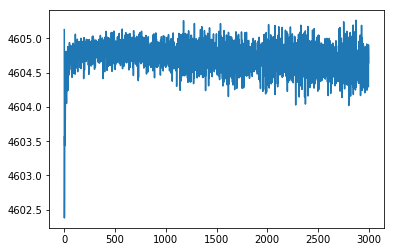

In [139]:
plt.plot(range(len(loss_list)), loss_list)

In [140]:
np.min(loss_list)

4602.379352866155

In [141]:
test_x,test_y = mn.test.next_batch(batch_size)
y = predict(test_x,params)

In [142]:
y.shape

(10, 2000)

In [143]:
np.mean(np.argmax(y, axis = 0) == np.argmax(test_y,axis = 1))

0.1195